In [478]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import os
from sklearn.metrics import mean_squared_error

In [479]:
# EEG channels (AUX_1 == EMG)
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2','AUX_1', 'ACC_X', 'ACC_Y', 'ACC_Z']

# Electrodes removed from EEG
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# Eye Tracker channels
eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink', 'left_openness', 'right_openness']

# Add both channel names to colums for use in DataFrame later
columns =  eye_data_names + channels


In [480]:
def get_time_stamps(stamps: list):
    start = []
    end = []
    more_than_one = False
    # Loops list of timestamps, if there is a value for old value n, where the new value is n + 1, continue, if not, then
    # The start of the list is the start of the blink, then the last value where n + 1 is valid, is the end of the blink
    for i in range(len(stamps)):
        if i == (len(stamps)-1):
            if(stamps[i-1] == (stamps[i] - 1)):
                end.append(stamps[i])
            break

        if(stamps[i] == (stamps[i+1] - 1)):
            if not more_than_one:
                start.append(stamps[i])
            more_than_one = True
            continue
        else:
            if more_than_one:
                end.append(stamps[i])
                more_than_one = False

    return start, end

def detect_blinks(eye_openness, threshold=0.2, tolerance=0.3):
    blink_start = []
    blink_end = []
    in_blink = False
    start_index = None

    for i, value in enumerate(eye_openness):
        if value <= threshold:
            # If the eye openness is below the threshold, consider it as part of a blink
            if not in_blink:
                start_index = i
                in_blink = True
        elif in_blink:
            # If the eye openness increases, check if it's still part of the same blink
            if value > threshold + tolerance:
                in_blink = False
                blink_start.append(start_index)
                blink_end.append(i - 1)

    return blink_start, blink_end


In [481]:
"""
Plots a single EEG channel and Eye Tracking data with normalisation for better plot view
"""
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    y = ((df_norm + plus) *(-1 if flip else 1) *scale).tolist()
    peaks, _ = signal.find_peaks(y)
    peaks = [peak for peak in peaks]


    axis.plot(df_ts['time'][start-rang:end+rang], y, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    for i in peaks:
        plt.plot(df_ts['time'][i+ start - rang], y[i], marker="o", markersize=5, markeredgecolor="turquoise", markerfacecolor="black", label="Local maximum " + str(round(y[i])) + ", " + str(i+ start - rang))
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Amplitude ")
    axis.set_title(column)
    plt.legend()
    plt.show()
"""
Plots a single EEG channel and Eye Tracking data

"""
def plot_eeg_blink_single(df,df_ts, start, end,column,rang = 50):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")

    axis.plot(df_ts['time'][start-rang:end+rang], df[column], label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], df['left_openness'], color='orange', label = "Eye openness left - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], df['right_openness'], color='violet', label = "Eye openness right - SRanipal")
    axis.set_title(column)
    plt.legend()
    plt.show()

In [482]:
from scipy.signal import resample

"""
Inits the stream data. Used to get a dataframe with the eye tracking data, and the eeg data for easier data processing
"""
def init_data(data, shift = 0):
    streams = []
    for s in data:
        for t in s:
            streams.append(t)

    #Resample
    resample_ = True
    signal_resampled = streams[1]['time_series']
    df_stream = pd.concat([pd.DataFrame(streams[0]['time_series']), pd.DataFrame(signal_resampled)], axis=1)
    df_stream_ts = pd.DataFrame(streams[0]['time_stamps'])
    #df_stream_ts_eeg = pd.DataFrame(streams[1]['time_stamps'])
    df_stream_ts.columns = ['time']
    #df_stream_ts_eeg.columns = ['time_eeg']
    df_stream.columns = columns
    df_stream['AUX_1'] = df_stream['AUX_1']+ 1000000



    # Check if NANs have any impact (if streams are unsynced because of different length, but it suggests that
    # The streams end on different points, but start on same
    num_rows_with_nan = df_stream.isna().any(axis=1).sum()
    #print(num_rows_with_nan)

    eye_stream = len(streams[0]['time_series'])
    eeg_stream = len(streams[1]['time_series'])

    if eye_stream > eeg_stream:
        df_stream[channels] = df_stream[channels].shift(round(num_rows_with_nan/ 3) )
        pass
    if eeg_stream > eye_stream:
        df_stream[eye_data_names] = df_stream[eye_data_names].shift(round(num_rows_with_nan/ 3) )
        pass

    if shift != 0:
        df_stream['AUX_1'] = df_stream['AUX_1'].shift(shift)

    df_stream.dropna(inplace=True)
    df_stream = df_stream.reset_index()
    #df_stream_ts = pd.concat([df_stream_ts_eye, df_stream_ts_eeg], axis=1)
    #df_stream_ts['diff'] = df_stream_ts['time']-df_stream_ts['time_eeg']
    df_stream_ts.dropna(inplace=True)
    #print(df_stream_ts)
    return streams, df_stream, df_stream_ts

"""
Returns a list of indexes where the user blinked with the left eye, right eye and both eyes
"""
def get_blinks_in_df(df):
    left_blinks = df.index[(df['left_blink'] >= 1) & (df['right_blink'] != 1)].tolist()
    right_blinks = df.index[(df['right_blink'] >= 1) & (df['left_blink'] != 1)].tolist()
    both_blink = df.index[df['both_blink'] == 1].tolist()
    #both_blink = df.index[(df['right_openness'] <= 0.1) & (df['left_openness'] <= 0.1)].tolist()
    return left_blinks,right_blinks, both_blink


In [483]:
# Same as EMG channel
chosen_channel = 'AUX_1'


In [484]:
"""
If there are multiple peaks in a curve, take the mean point to ensure best accuracy
"""
def find_close_values_mean(values,y, tolerance):
    values.sort()
    peak = values[np.argmax([y[i] for i in values])]
    # Loop list and compare elements
    for i in range(len(values) - 1):
        if abs(values[i] - peak) <= tolerance and values[i] != peak:
            # Return mean if two values are close
            return (values[i] + values[i + 1]) / 2

    return peak
"""
Return peaks in signal in specified range and normalizes data before finding peak
"""
def get_peaks(df, start, end, column, rang=50, scale=1, flip=True):

    df = df[start - rang:end + rang]
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    y = ((df_norm + plus) *(-1 if flip else 1) *scale).tolist()
    peaks, _ = signal.find_peaks(y)
    peaks = [peak for peak in peaks]
    if len(peaks) == 0:
        #print(df)
        return 0

    peak = find_close_values_mean(peaks, y, 20)+ start - rang
    return  peak



In [485]:
"""
Find the mean shift in the data for best synchronization between EEG and EYE Tracker
"""
def find_shift(start, peaks):
    differences_start = []
    for i in range(len(peaks)):
        differences_start.append(start[i]-peaks[i])
    return differences_start


In [486]:

"""
Method to apply a zero-phase Butterworth filter to the data
Uses bandpass [0.75-5], and order 4
"""
def zero_phase_butter(data):
    # Butterworth filter parameters
    fs = 250
    lowcut =0.75
    highcut = 5.0
    order = 4

    # Design Butterworth bandpass filter
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b_bandpass, a_bandpass = signal.butter(order, [low, high], btype="band")

    # Zero-phase filtering using filtfilt
    return signal.filtfilt(b_bandpass, a_bandpass, data)

"""
Method to import files with EEG and Eye Tracker data, and make them into common DataFrame for easier analysis
"""

def run_files(paths, path='data/LSLGoodData/', both = True, plot = False, shift_init=0):
    t = True
    peak_info = []
    avg_time = []
    for (index,y) in enumerate(paths):

        data_eeg, header = pyxdf.load_xdf(path+str(y)+'/decimated-dejittered-eeg.xdf')

        data_eye, header = pyxdf.load_xdf(path+str(y)+'/dejittered-gaze-and-blinking.xdf')

        stream, df_stream, df_stream_ts = init_data([data_eye, data_eeg],shift_init)

        # Adding butterworth
        df_stream['AUX_1'] = zero_phase_butter(df_stream['AUX_1'])

        #left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)
        start, end = detect_blinks((df_stream['left_openness'] + df_stream['right_openness'])/2, tolerance=0.1, threshold=0.3)
        avg_time.append(np.diff(df_stream_ts.to_numpy().flatten()).tolist())

        peaks = []
        remove = []
        # Finding the 10 blinks done in testing 
        for s, e in zip(start, end):
            if s - 50 <= 0:
                remove.append((s,e))
                continue
            peaks.append(get_peaks(df_stream, s, e, chosen_channel, rang=50, scale=100, flip=both))
        
        for s, e in remove:
            start.remove(s)
            end.remove(e)
        # Finding the mean shift based on the ten blinks
        shift = find_shift(start, peaks)
        # Adding the shift to info for later use and comparison
        peak_info.append(shift)


    n = len(max(peak_info, key=len))
    # Make empty list of peaks for later adding
    t = [x + [None]*(n-len(x)) for x in peak_info]
    # Make array with peak info
    numpy_array_peak_info = np.array(t)
    df_peak = pd.DataFrame(numpy_array_peak_info)
    df_peak = df_peak.set_index([paths])
    # Add time between index column in dataframe with average time between indexes
    df_peak = df_peak.applymap(lambda x: x if x is not None else np.nan)
    new_columns_df = pd.DataFrame()

    # Calculate the time between indexes
    # Add sum, average, and average time shift columns
    new_columns_df['Sum (indexes)'] = df_peak.sum(axis=1, skipna=True)
    new_columns_df['Avg (indexes)'] = df_peak.mean(axis=1, skipna=True).round(3)
    new_columns_df['time between index (s)'] = [i[0] for i in avg_time]
    new_columns_df['Avg time (ms)'] = (new_columns_df['Avg (indexes)'] * new_columns_df['time between index (s)'] * 1000).round(5)

    # Merge the new DataFrame with df_peak
    df_peak = pd.concat([df_peak, new_columns_df], axis=1)
    return df_peak



In [487]:
path = "./data/subject2/"
paths = [name for name in os.listdir(path)]
both = [name for name in paths]
flip = False

df_both = run_files(both,path=path, both=flip , plot=False)
display(df_both)


,0,1,2,3,4,5,6,7,8,9,10,11,12,Sum (indexes),Avg (indexes),time between index (s),Avg time (ms)
LSLData_s2_1,-15,-23,-29,-42,-32,-28,-22,-19,-24,-21.0,-17.0,NaN,NaN,-272.0,-24.727,0.004,-98.90322
LSLData_s2_10,-9,-10,-11,-15,-16,-10,-14,-14,-13,-10.0,-16.0,-12.0,NaN,-150.0,-12.500,0.004,-49.99808
LSLData_s2_11,-11,-14,-22,-13,-19,-16,-13,-15,-22,-26.0,NaN,NaN,NaN,-171.0,-17.100,0.004,-68.39733
LSLData_s2_12,-12,-17,-18,-18,-21,-21,-28,-19,-22,-23.0,-18.0,NaN,NaN,-217.0,-19.727,0.004,-78.90617
LSLData_s2_13,-11,-16,-20,-15,-16,-12,-13,-15,-9,-16.0,NaN,NaN,NaN,-143.0,-14.300,0.004,-57.19813
LSLData_s2_14,-18,-32,-23,-23,-22,-24,-18,-20,-30,-26.0,-23.0,NaN,NaN,-259.0,-23.545,0.004,-94.17578
LSLData_s2_15,-14,-12,-18,-20,-22,-31,-23,-25,-15,-20.0,-11.0,-12.0,-12.0,-235.0,-18.077,0.004,-72.30662
LSLData_s2_16,-15,-19,-18,-21,-17,-19,-29,-35,-26,-31.0,-13.0,NaN,NaN,-243.0,-22.091,0.004,-88.36219
LSLData_s2_17,-19,-22,-26,-25,-26,-28,-23,-20,-34,-27.0,26.0,NaN,NaN,-224.0,-20.364,0.004,-81.45238
LSLData_s2_18,-13,-22,-19,-23,-20,-49,-30,-27,-16,-26.0,NaN,NaN,NaN,-245.0,-24.500,0.004,-97.99513


In [488]:
# Returns average offset in entire dataset
def get_offset(df):
    avg_offset = df['Avg time (ms)'].sum()/df.shape[0]
    avg_offset_index = df['Avg (indexes)'].sum()/df.shape[0]
    return avg_offset, avg_offset_index



In [489]:
print("(Seconds, Number of indexes to shift) ---- Both")
print(get_offset(df_both))

# Run files again, but compensates the found offset
df_both_shift = run_files(both,path = path, both=flip , plot=False, shift_init=round(get_offset(df_both)[1]))
display(df_both_shift)

print(get_offset(df_both_shift))


(Seconds, Number of indexes to shift) ---- Both
(-77.70883400000001, -19.427880000000002)


,0,1,2,3,4,5,6,7,8,9,10,11,12,Sum (indexes),Avg (indexes),time between index (s),Avg time (ms)
LSLData_s2_1,4,-4,-10,-23,-13,-9,-3,0,-5,-2.0,2.0,NaN,NaN,-63.0,-5.727,0.004,-22.90689
LSLData_s2_10,10,9,8,4,3,9,5,5,6,9.0,3.0,7.0,NaN,78.0,6.500,0.004,25.99900
LSLData_s2_11,8,5,-3,6,0,3,6,4,-3,-7.0,NaN,NaN,NaN,19.0,1.900,0.004,7.59970
LSLData_s2_12,7,2,1,1,-2,-2,-9,0,-3,-4.0,1.0,NaN,NaN,-8.0,-0.727,0.004,-2.90793
LSLData_s2_13,8,3,-1,4,3,7,6,4,10,3.0,NaN,NaN,NaN,47.0,4.700,0.004,18.79938
LSLData_s2_14,1,-13,-4,-4,-3,-5,1,-1,-11,-7.0,-4.0,NaN,NaN,-50.0,-4.545,0.004,-18.17918
LSLData_s2_15,5,7,1,-1,-3,-12,-4,-6,4,-1.0,8.0,7.0,7.0,12.0,0.923,0.004,3.69193
LSLData_s2_16,4,0,1,-2,2,0,-10,-16,-7,-12.0,6.0,NaN,NaN,-34.0,-3.091,0.004,-12.36375
LSLData_s2_17,0,-3,-7,-6,-7,-9,-4,-1,-15,-8.0,45.0,NaN,NaN,-15.0,-1.364,0.004,-5.45576
LSLData_s2_18,6,-3,0,-4,-1,-30,-11,-8,3,-7.0,NaN,NaN,NaN,-55.0,-5.500,0.004,-21.99891


(-1.7259267999999997, -0.4315200000000001)


In [490]:
import statistics
from scipy.stats import sem
# Finding STD, SE and Mean
standard_de_both = statistics.stdev(df_both['Avg time (ms)'])
se_both = sem(df_both['Avg time (ms)'])
mean = statistics.mean(df_both['Avg time (ms)'])

print("Standard devation (ms) -----")
print("Both: " + str(standard_de_both))

print("-------- SE (ms) ----------")
print("Both: " + str(se_both))


Standard devation (ms) -----
Both: 20.128768377998608
-------- SE (ms) ----------
Both: 4.025753675599722


In [491]:
# Finding STD, SE and Mean

standard_de_both_shift = statistics.stdev(df_both_shift['Avg time (ms)'])
se_both_shift = sem(df_both_shift['Avg time (ms)'])
mean = statistics.mean(df_both_shift['Avg time (ms)'])

print("Standard devation (ms) - After shift")
print("Both: " + str(standard_de_both_shift))


print("-------- SE (ms) - After shift ----------")
print("Both: " + str(se_both_shift))


Standard devation (ms) - After shift
Both: 20.149071677473284
-------- SE (ms) - After shift ----------
Both: 4.029814335494657


[-0.3745429, -0.283628, -0.2759913, -0.22906890000000002, -0.2199891, -0.18179179999999998, -0.1723123, -0.1563546, -0.1527169, -0.1236375, -0.0545576, -0.0319994, -0.0290793, 0.0133195, 0.0159993, 0.0369193, 0.0679988, 0.07599700000000001, 0.0799962, 0.1879938, 0.1959968, 0.2199947, 0.25999, 0.34399430000000003, 0.35598820000000003]


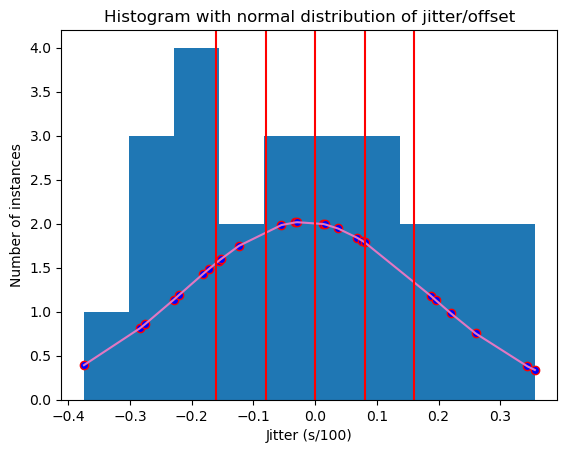

In [492]:
from scipy.stats import norm
# Plot between -10 and 10 with .001 steps.
x_axis = sorted((df_both_shift['Avg time (ms)']/100).tolist())
print(x_axis)

# Plots a histogram with normal distribution and red lines to mark the indexes, to present jitter data
plt.hist(x_axis)
for i in range(len(x_axis)):
    plt.plot(x_axis[i],  norm.pdf(x_axis,np.mean(x_axis),np.std(x_axis))[i], marker="o", markersize=6, markeredgecolor="red", markerfacecolor="blue")
index_secs = 0.08
plt.plot(x_axis, norm.pdf(x_axis,np.mean(x_axis),np.std(x_axis)))
plt.axvline(x=0, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=-index_secs, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=-index_secs*2, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=index_secs, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=index_secs*2, ymax=6, ymin=0, color='r', linestyle='-')
plt.title("Histogram with normal distribution of jitter/offset")
plt.xlabel("Jitter (s/100)")
plt.ylabel("Number of instances")
plt.show()

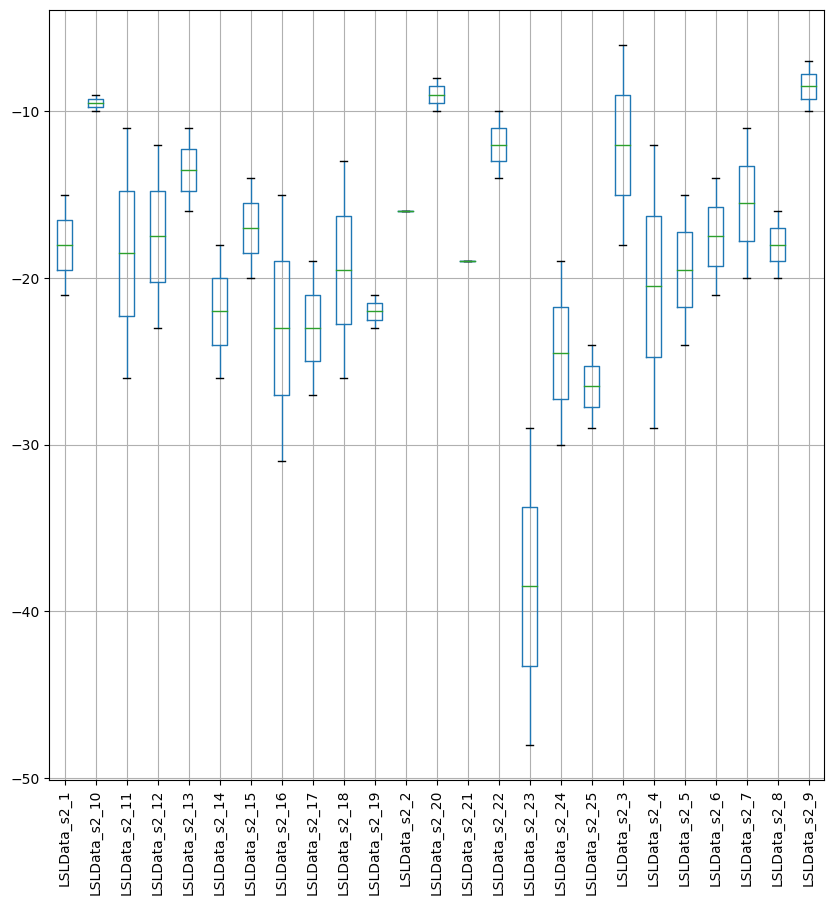

In [493]:

boxplot = df_both.iloc[:, [0, 9]].T.boxplot(figsize=(10,10), rot=90)

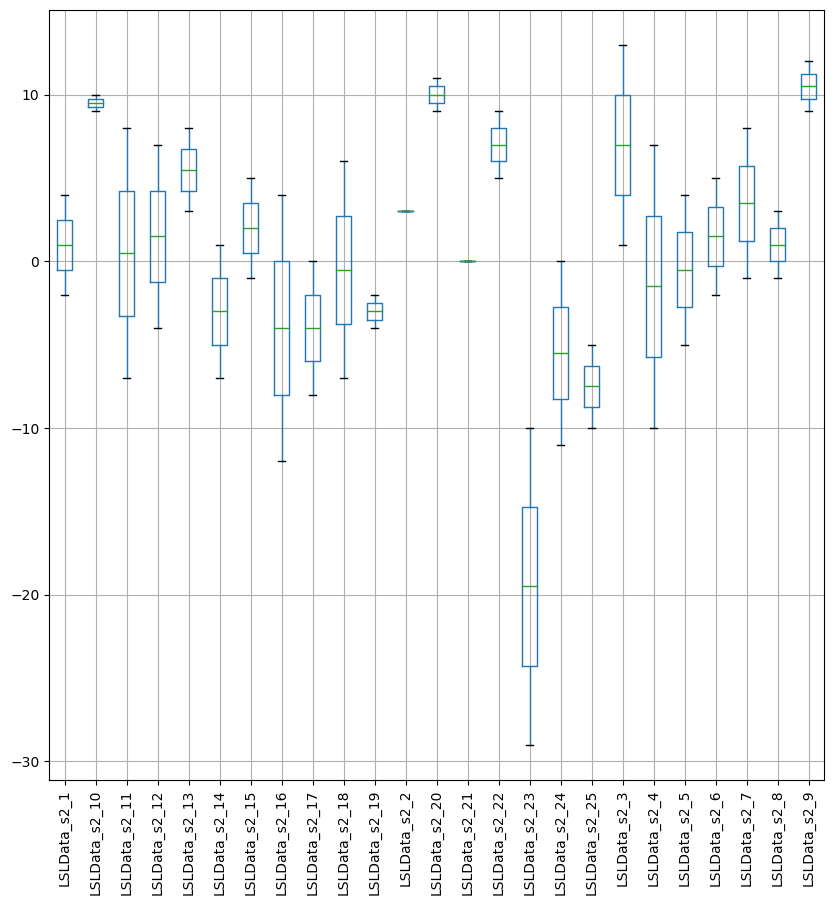

In [494]:
boxplot = df_both_shift.iloc[:, [0, 9]].T.boxplot(figsize=(10,10), rot=90)
